#Conversion in Conic form

We start from the log-barrier Risk Parity problem:

$$
\begin{aligned}
& \underset{x}{\text{min}}
&&\frac{1}{2} x^T \Sigma x - c \sum_{i=1}^{n} b_i ln(x_i)\\
& \text{s.t.}
&& x_i > 0 \hspace{1em} \forall i
\end{aligned}
$$

We now introduce an auxiliary vector of $n$ variables $t$:

$$
\begin{aligned}
& \underset{x}{\text{min}}
&&\frac{1}{2} x^T \Sigma x - c \sum_{i=1}^{n}t_i\\
& \text{s.t.}
&& t_i \leq b_i ln(x_i) \hspace{1em} \forall i \\
&&& x_i > 0 \hspace{1em} \forall i
\end{aligned}
$$

The covariance matrix $\Sigma$ is positive semidefinite by definition and therefore there exist a matrix $G$ such that

$$
\Sigma = G G^T
$$

In general the choice of $G$ is not unique and one possible choice of $G$ is the Cholesky factorization of $\Sigma$. For a given $G$ we have that

$$
x^T \Sigma x = x^T G G^T x \\= ||\text{ } G^Tx \text{ }||^2
$$

If we introduce another auxiliary variable $z$, we have

$$
\begin{aligned}
& \underset{x}{\text{min}}
&&z - c \sum_{i=1}^{n}t_i\\
& \text{s.t.}
&& \frac{1}{2}z \geq ||\text{ } G^Tx \text{ }||^2\\
&&& t_i \leq b_i ln(x_i) \hspace{1em} \forall i \\
&&& x_i > 0 \hspace{1em} \forall i
\end{aligned}
$$

The constraint 

$$
\frac{1}{2}z \geq ||\text{ } G^Tx \text{ }||^2
$$

can be written as

$$
(z,1,Gx) \in \mathcal{Q}^{n+2}_r
$$

#MOSEK Fusion Implementation

First of all, we generate the random covariance matrix $Q$ and the random budget vector $b$

In [6]:
import numpy as np
import cuts

n=10

#random covariance matrix
A = np.random.sample([n,n])
Q = np.dot(A,A.transpose())

#random budget vector
b = np.random.sample(n)
b = b/np.sum(b)

Now, the Cholesky factorization of the covariance matrix is performed. The result is saved in the variable $G$.

In [7]:
from scipy import linalg 
from mosek.fusion import *

chol = linalg.cholesky(Q)
G = DenseMatrix(chol)

We use the <a>MOSEK Fusion API</a> to define a $\textbf{model}$. We initialize the model with the three vector of variables, $x$, $t$ and $z$ and then define the first constraint, i.e. 
$$(z,1,Gx) \in \mathcal{Q}^{n+2}_r$$

In [8]:
with Model("Log-Barrier") as M:
    #define the variables
    x = M.variable("x", n, Domain.greaterThan(0.0))
    t = M.variable("t", n, Domain.lessThan(0.0))
    z = M.variable("z", 1, Domain.greaterThan(0.0))

    M.constraint(Expr.vstack(Expr.constTerm(1, 1.0),
                 z.asExpr(),
                 Expr.mul(G,x)),
                 Domain.inRotatedQCone())
    
    M.objective(ObjectiveSense.Minimize, Expr.sub(z, Expr.sum(t)))
    M.solve()
    
    convergence = False
    epsilon = 0.000000001
    k=0
    while (not convergence):       
        [m, c] = cuts.generateCuts(t.level(), x.level(), b, n, epsilon)
        if not np.equal(m.all(),np.zeros(n).all()):
            m_coeff = np.diag(m)
            M.constraint(Expr.sub(t, Expr.mul(m_coeff,x)), Domain.lessThan(c))               
            M.solve()                
        else:
            convergence = True
            k = k+1 
    xx =  x.level()/np.sum(x.level())

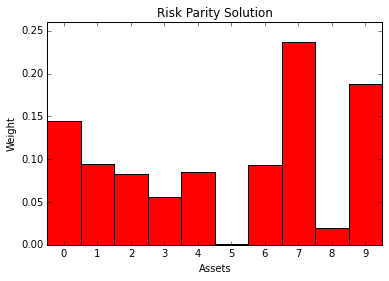

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import barchart

barchart.plot_bar(xx, 'r', 'Risk Parity Solution', 'Assets', 'Weight')

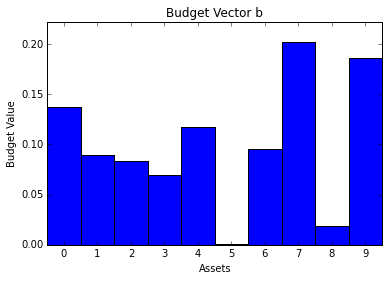

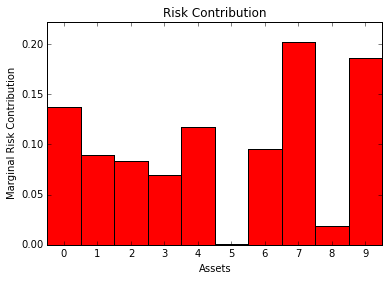

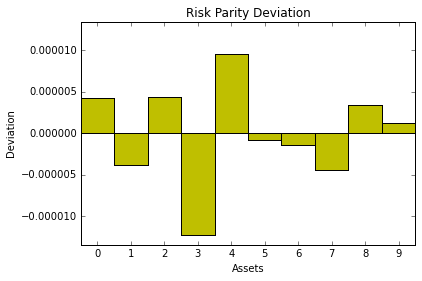

In [10]:
RC = np.zeros(n)
aux = Q.dot(xx)
volatility = xx.dot(aux)
for i in range(n):
    RC[i]=xx[i]*aux[i]/volatility
    
#print budget vector
barchart.plot_bar(b, 'b', 'Budget Vector b', 'Assets', 'Budget Value')

#print marginal risk contribution
barchart.plot_bar(RC, 'r', 'Risk Contribution', 'Assets', 'Marginal Risk Contribution')

#print the differences between the two above
barchart.plot_bar(RC-b, 'y', 'Risk Parity Deviation', 'Assets', 'Deviation')
    
 

<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">MOSEK Fusion API Notebook</span> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>.